<a href="https://colab.research.google.com/github/decoz/mlclass/blob/master/ch7_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask RCNN 

RCNN중에 가장 발전된 형태인 Mask-RCNN은 네트워크의 구조가 복잡해서 아직 케라스 내부 라이브러리에서 지원하지 안는다. 또한 동시에 엄청난 학습 시간을 필요로 하니 이번 시간엔 이를 구현한 외부코드를 이용해 사용하는 방법을 한번 체험해본다. 

먼저 가장 널리 알려진 Keras RCNN 코드는 https://github.com/matterport/Mask_RCNN.git 에 존재한다. 이 소스를 카피하는 git 명령어를 실행시켜보자 



### 설치 (matterport 버젼)

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 32.04 MiB/s, done.
Resolving deltas: 100% (566/566), done.


이 코드를 실행하기 위해서 필요한 패키지는 다음과 같다. 특히 텐서플로우의 하위버젼이 필요한데 이럴땐 colab 의 가상 환경이 도움이 되니 부담없이 다운그래이드를 해준다. 

In [ ]:
!pip install pycocotools
!pip install mrcnn|
!pip install tensorflow==1.9.0
!pip install keras==2.2.0
print("Installed packages")

작업을 원할하게 하기 위해 현재 디렉토리를 위에서 다운받은 폴더로 이동해준다. 

In [3]:
import os
os.chdir('/content/Mask_RCNN/')

파이썬 소스에 setup.cfg 와 setup.py 가 있을 경우는 대부분 이 코드를 인스톨이 가능하다. 이를 인스톨 하는 명령은 다음과 같다. 

In [ ]:
!python setup.py install 

### 모델 로딩 

다음은 모델을 로딩하기 위한 준비단계이다.  먼저 모델을 파일로 다운로드 받도록 하겠다. 

In [14]:
import coco 
from mrcnn import utils
utils.download_trained_weights("mask_rcnn_coco.h5")


... done downloading pretrained model!


이제 좌측 파일 탭을 보면 Mask_RCNN 폴더에 mask_rcnn_coco.h5 파일이 생긴 것을 볼 수 있다. 이제 이 파일을 로딩하도록 하겠다.  간단하게 load_model 하면 되는 다른 모델과 달리 mrcnn 은 망구조와 weight 를 따로 로딩한다. 

In [16]:
import mrcnn.model as modellib
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=ROOT_DIR)
model.load_weights(COCO_MODEL_PATH, by_name=True)


### 모델 테스트 

이제 모델로 이미지를 테스트 하기전에 각 클래스별 레이블이 필요하다. 이는 학습한 데이터에 따라 다른데 우리가 로딩한 데이터의 레이블은 다음과 같다. 


In [17]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

일반적인 케라스 모델과는 달리 커스텀 모델을 정의해 쓰기 때문에 predict 대신 detect 를 사용한다. 그러면 먼저 이미지 디렉토리에 있는 샘플 이미지중에 랜덤 이미지를 읽어서 시각화 하는 코드를 보도록 하겠다. 



Processing 1 images
image                    shape: (334, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


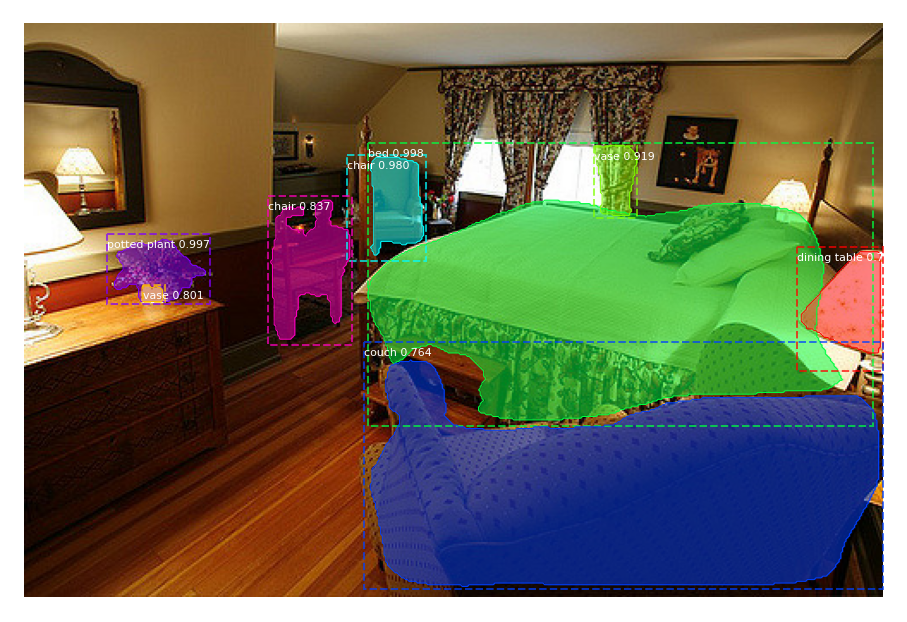

In [18]:
from mrcnn import visualize
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

result 값 역시 일반적인 모델과 달리 dictionary 형태로 리턴되며 시각화 역시 mrcnn 에서 자체적으로 지원된다. 

In [5]:
#import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from mrcnn.config import Config

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

# Root directory of the project
ROOT_DIR = os.path.abspath("./")


import warnings
warnings.filterwarnings("ignore")

 #Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
 #Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco



%matplotlib inline

Using TensorFlow backend.


In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


In [7]:
import numpy
import scipy
import PIL
import tensorflow
import skimage
import h5py
import IPython
import cv2
import keras
import scipy
import matplotlib
import cython

print("All dependencies are installed")

All dependencies are installed


In [8]:
class InferenceConfig(coco.CocoConfig):
  #class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=ROOT_DIR)


In [10]:
from keras.engine import saving
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [11]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (640, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


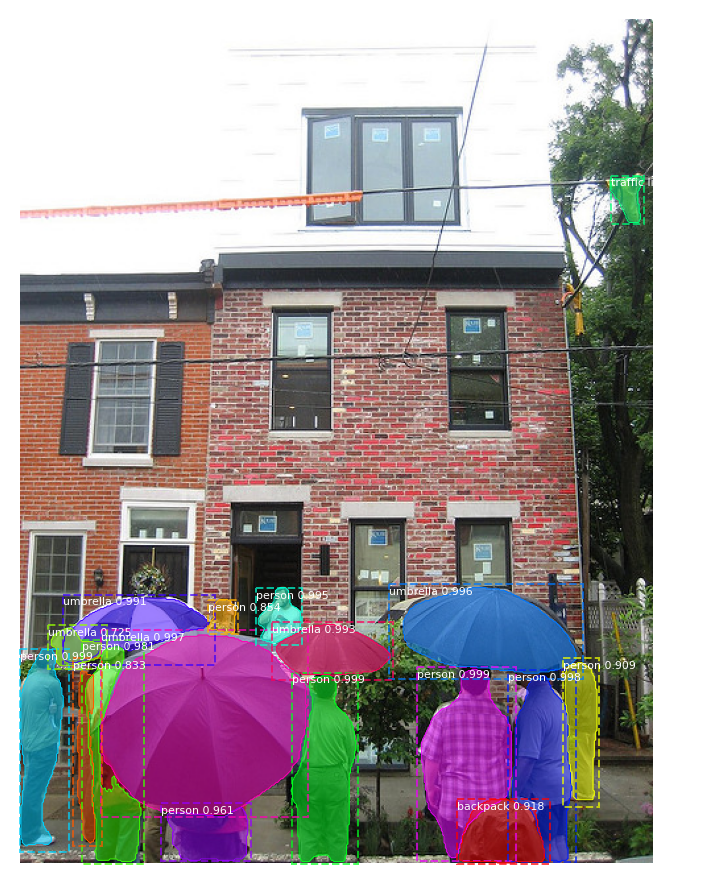

In [13]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])